<a href="https://colab.research.google.com/github/aayushsss1/Neural-Style-Transfer-Using-PyTorch/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning with PyTorch : Neural Style Transfer

Install Pytorch

In [26]:
!pip install torch torchvision

Pictures

## Loading VGG Pretrained Model

In [28]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We do not need the classifier part, we just need to extract the features from the convolutional layer

In [29]:
vgg = vgg.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Prevent the gradients from updating the weights or biases, freeze the model

In [30]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False) #freeze the layers

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Move to the GPU

In [32]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

Process and load the image

In [33]:
from PIL import Image
from torchvision import transforms as T 

def preprocess(img_path,max_size=500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean =[0.485,0.456,0.406], std= [0.229,0.224,0.225])
  ])

  image = img_transforms(image)

  image = image.unsqueeze(0) #(3,224,224) -> (1,3,224,224)
  return image

In [34]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style10.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print('Content Shape',content_p.shape)
print('Style Shape',style_p.shape)

Content Shape torch.Size([1, 3, 259, 345])
Style Shape torch.Size([1, 3, 500, 765])


## Deprocess image

Plot the Image

In [35]:
import numpy as np
import matplotlib.pyplot as plt
def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy() #convert to numpy format
  image = image.squeeze(0) #(1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0) # (3,224,224) -> (224,224,3)
  image = image * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
  image = image.clip(0,1)
  return image

In [36]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)
print('Deprocess Content:', content_d.shape)
print('Deprocess Style:', style_d.shape)

Deprocess Content: (259, 345, 3)
Deprocess Style: (500, 765, 3)


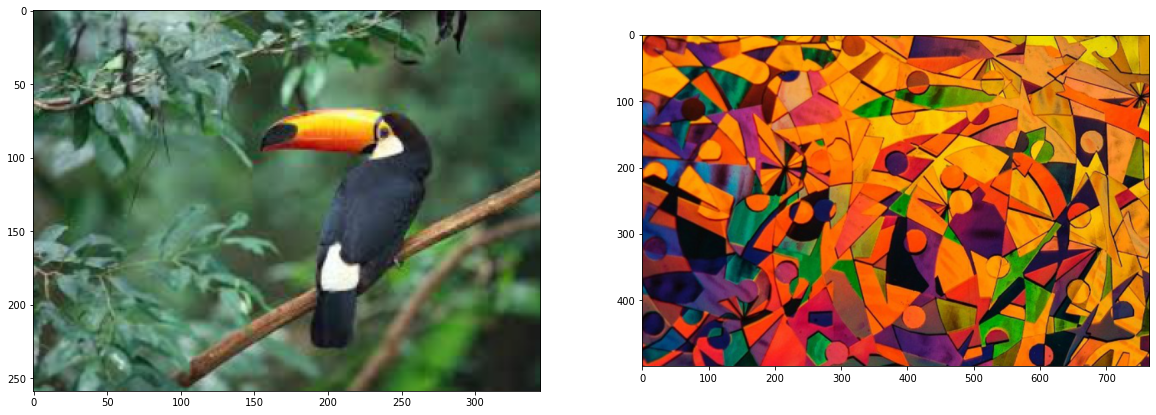

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

## Get content,Style features and Create gram matrix

Getting the Content

In [38]:
def get_features(image,model):
  layers = {
      '0':'conv1_1',
      '5':'conv2_1',
      '10':'conv3_1',
      '19':'conv4_1',
      '21':'conv4_2',
      '28':'conv5_1'
  } # mapping the convolutional layers
  x = image
  Features ={}
  for name, layer in model._modules.items():
    x = layer(x) #output of one layer is the input of another layer
    if name in layers:
      Features[layers[name]] = x
  return Features

In [39]:
content_f = get_features(content_p,vgg)
style_f = get_features(style_p,vgg)

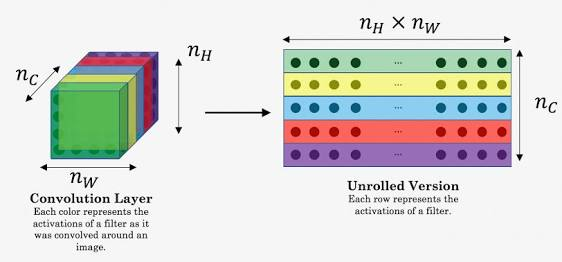

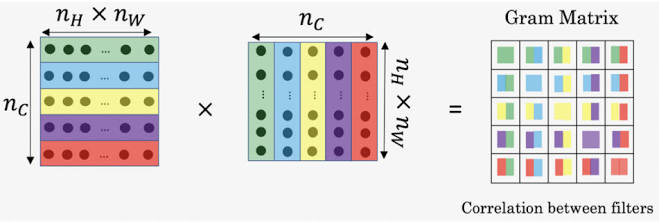

In [40]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor=tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [41]:
style_grams = {layer:gram_matrix(style_f[layer]) for layer in style_f}

## Creating Style and Content loss function

Content Loss = Target - Content

In [42]:
def content_loss(target_conv4_2,content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [43]:
style_weights = {
    'conv1_1':1.0,
    'conv2_1':0.75,
    'conv3_1':0.2,
    'conv4_1':0.2,
    'conv5_1':0.2
}#Mapping 

Style Loss = Target Gram - Style Gram

In [44]:
def style_loss(style_weights,target_features,style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] *torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)
  return loss

In [45]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("Content Loss: ",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss: ",style_loss(style_weights,target_f,style_grams))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss:  tensor(10744.7334, device='cuda:0', grad_fn=<AddBackward0>)


## Training loop

In [46]:
from torch import optim
optimizer = optim.Adam([target],lr=0.003)
alpha = 1
beta = 1e5
epochs = 3000
show_every = 500

In [47]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss=alpha*c_loss+beta*s_loss
  return loss

In [48]:
results =[]
for i in range(epochs):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)
  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()
  if i % show_every ==0:
    print('Total loss at epoch {} : {}'.format(i,t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0 : 1074473344.0
Total loss at epoch 500 : 378172224.0
Total loss at epoch 1000 : 243207104.0
Total loss at epoch 1500 : 152418032.0
Total loss at epoch 2000 : 93324816.0
Total loss at epoch 2500 : 63398168.0


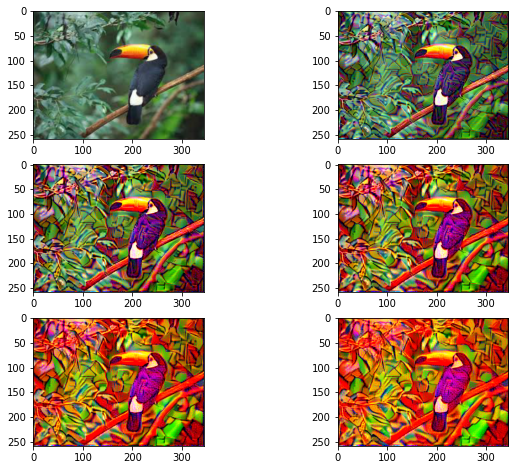

In [49]:
plt.figure(figsize=(10,8))
for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

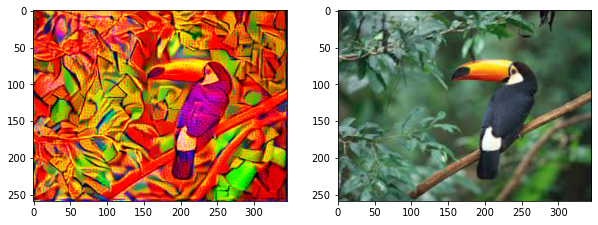

In [50]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)